In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


# ---------- Utilities ----------
def extract_station_info(station_field: str):
    if not station_field or "(" not in station_field or ")" not in station_field:
        return None, None
    code = station_field.split(")")[0].replace("(", "").strip()
    name = station_field.split(")")[1].strip()
    return code, name


def build_counts(df, window="5min"):
    """Aggregate check-ins per time window and add time features."""
    df["window"] = df["Fecha_Transaccion"].dt.floor(window)
    counts = (
        df.groupby("window")
        .size()
        .reset_index(name="count")
        .sort_values("window")
    )
    counts["hour"] = counts["window"].dt.hour
    counts["dow"] = counts["window"].dt.dayofweek
    counts["minute_of_day"] = counts["hour"] * 60 + counts["window"].dt.minute
    return counts


def fit_models(counts):
    """Fit Poisson and NB models and compare."""
    print(f"📊 Fitting models on {len(counts)} intervals")

    # Poisson model
    poisson_mod = smf.glm(
        "count ~ C(hour)",
        data=counts,
        family=sm.families.Poisson()
    ).fit()

    # Negative Binomial model
    nb_mod = smf.glm(
        "count ~ C(hour)",
        data=counts,
        family=sm.families.NegativeBinomial()
    ).fit()

    print("\n=== Poisson summary ===")
    print(poisson_mod.summary())
    print("\n=== Negative Binomial summary ===")
    print(nb_mod.summary())

    print("\nAIC comparison:")
    print(f"Poisson AIC: {poisson_mod.aic:.2f}")
    print(f"NegBin  AIC: {nb_mod.aic:.2f}")

    vmr = counts["count"].var() / counts["count"].mean()
    print(f"\nVariance-to-mean ratio: {vmr:.2f}")
    if vmr > 1.2:
        print("⚠️ Overdispersion detected (NB justified).")
    else:
        print("✅ Poisson dispersion acceptable.")

    return poisson_mod, nb_mod


def plot_residuals(model, title):
    """Residuals vs fitted plot."""
    plt.figure(figsize=(8, 4))
    plt.scatter(model.fittedvalues, model.resid_pearson, alpha=0.6)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel("Fitted counts")
    plt.ylabel("Pearson residuals")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ---------- Main ----------
def main(file_code, station_code, window="5min"):
    folder_path = "../../../../data/check_ins/daily"
    file_path = os.path.join(folder_path, f"{file_code}.csv")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        sys.exit(1)

    print(f"📂 Loading data from {file_path}")
    df = pd.read_csv(file_path,
        usecols=["Fecha_Transaccion", "Estacion_Parada"],
        parse_dates=["Fecha_Transaccion"])
    df["station_code"], df["station_name"] = zip(*df["Estacion_Parada"].apply(extract_station_info))
    df = df[df["station_code"] == station_code]
    if df.empty:
        print(f"⚠️ No data found for station {station_code}")
        sys.exit(1)

    print(f"✅ Loaded {len(df)} check-ins for station {station_code}")

    counts = build_counts(df, window=window)
    print(counts.head())

    poisson_mod, nb_mod = fit_models(counts)

    plot_residuals(poisson_mod, "Poisson model residuals")
    plot_residuals(nb_mod, "Negative Binomial model residuals")

    # Optional: overlay fitted means
    plt.figure(figsize=(10,4))
    plt.plot(counts["window"], counts["count"], label="Observed counts", alpha=0.6)
    plt.plot(counts["window"], nb_mod.fittedvalues, label="NB fitted mean", color="red")
    plt.title(f"Observed vs NB fitted counts — Station {station_code}")
    plt.xlabel("Time")
    plt.ylabel("Check-ins per window")
    plt.legend()
    plt.tight_layout()
    plt.show()


📂 Loading data from ../../../../data/check_ins/daily\20251014.csv
✅ Loaded 18216 check-ins for station 07107
               window  count  hour  dow  minute_of_day
0 2025-10-14 04:30:00      4     4    1            270
1 2025-10-14 04:35:00      1     4    1            275
2 2025-10-14 04:40:00      2     4    1            280
3 2025-10-14 04:50:00      1     4    1            290
4 2025-10-14 04:55:00      6     4    1            295
📊 Fitting models on 222 intervals


d:\dequi\repositories\osltm\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



=== Poisson summary ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  222
Model:                            GLM   Df Residuals:                      202
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1149.5
Date:                Sun, 02 Nov 2025   Deviance:                       1008.8
Time:                        01:24:28   Pearson chi2:                 1.01e+03
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.0

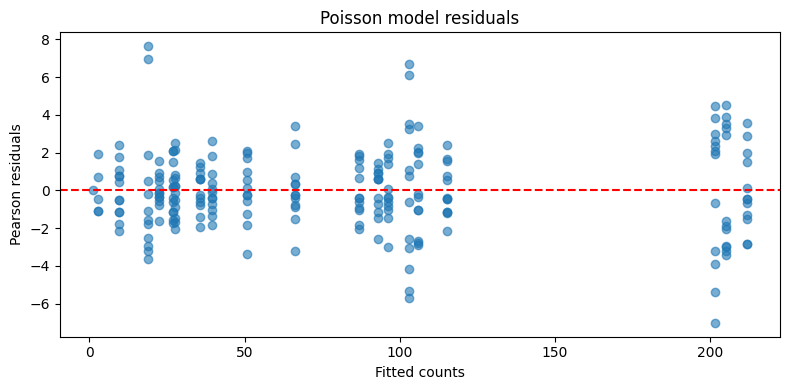

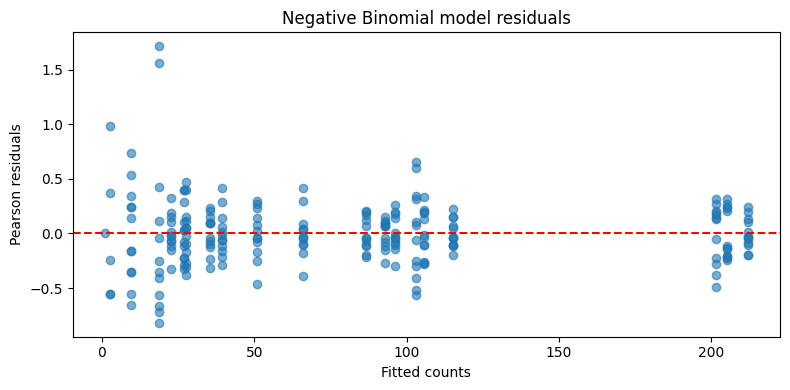

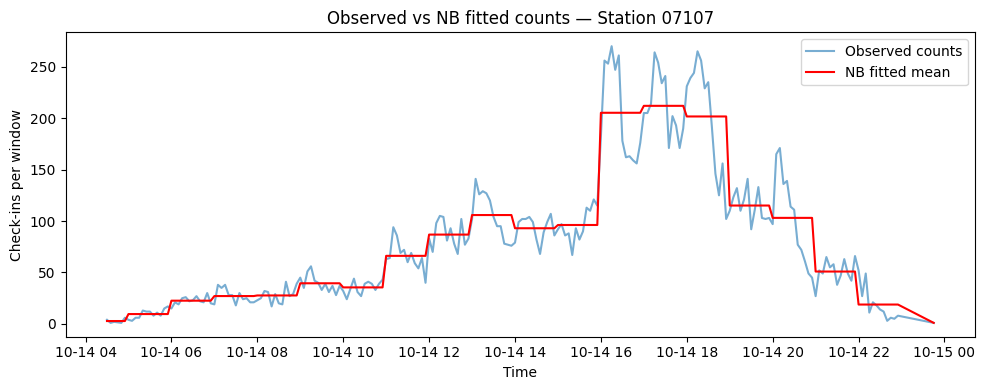

In [3]:
main("20251014", "07107")

📂 Loading data from ../../../../data/check_ins/daily\20251014.csv
✅ Loaded 41571 check-ins for station 02300
               window  count  hour  dow  minute_of_day
0 2025-10-14 04:30:00      2     4    1            270
1 2025-10-14 04:35:00      2     4    1            275
2 2025-10-14 04:40:00      8     4    1            280
3 2025-10-14 04:45:00      3     4    1            285
4 2025-10-14 04:50:00      4     4    1            290
📊 Fitting models on 225 intervals

=== Poisson summary ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                  225
Model:                            GLM   Df Residuals:                      205
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1426.2
Date:                Sun, 02

d:\dequi\repositories\osltm\.venv\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


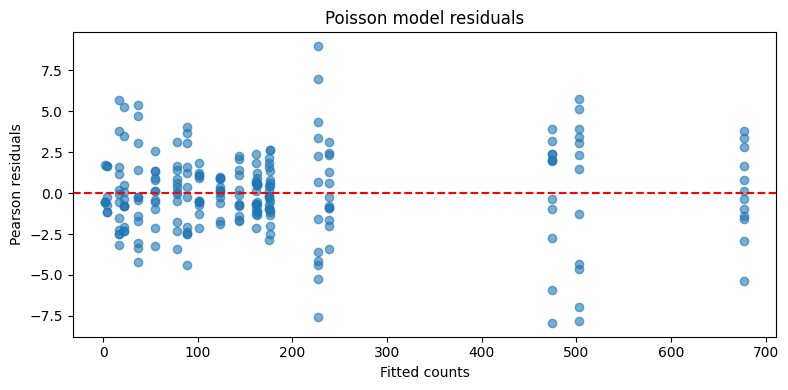

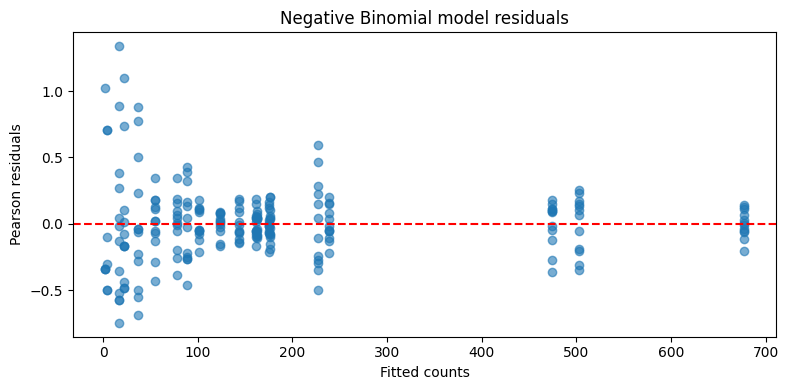

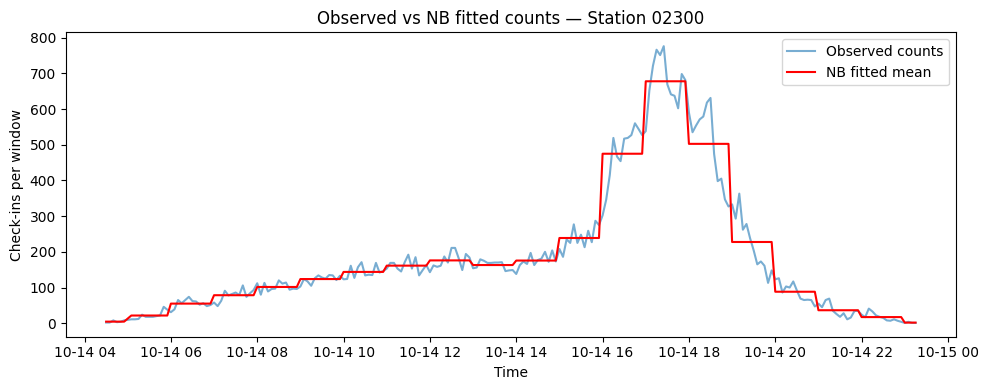

In [2]:

main("20251014", "02300")